# Pneumonia Detection
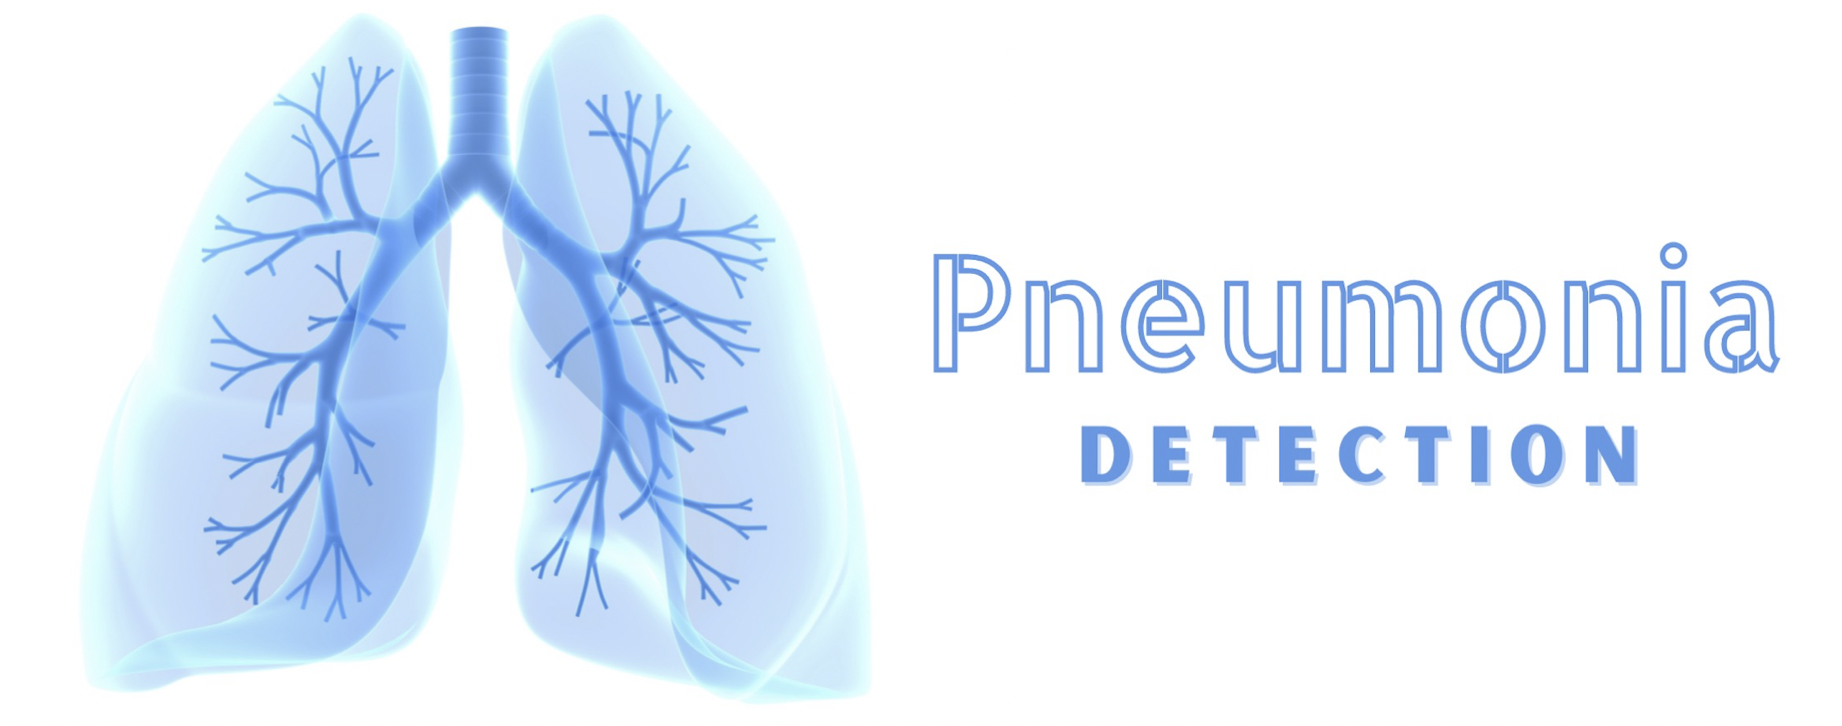
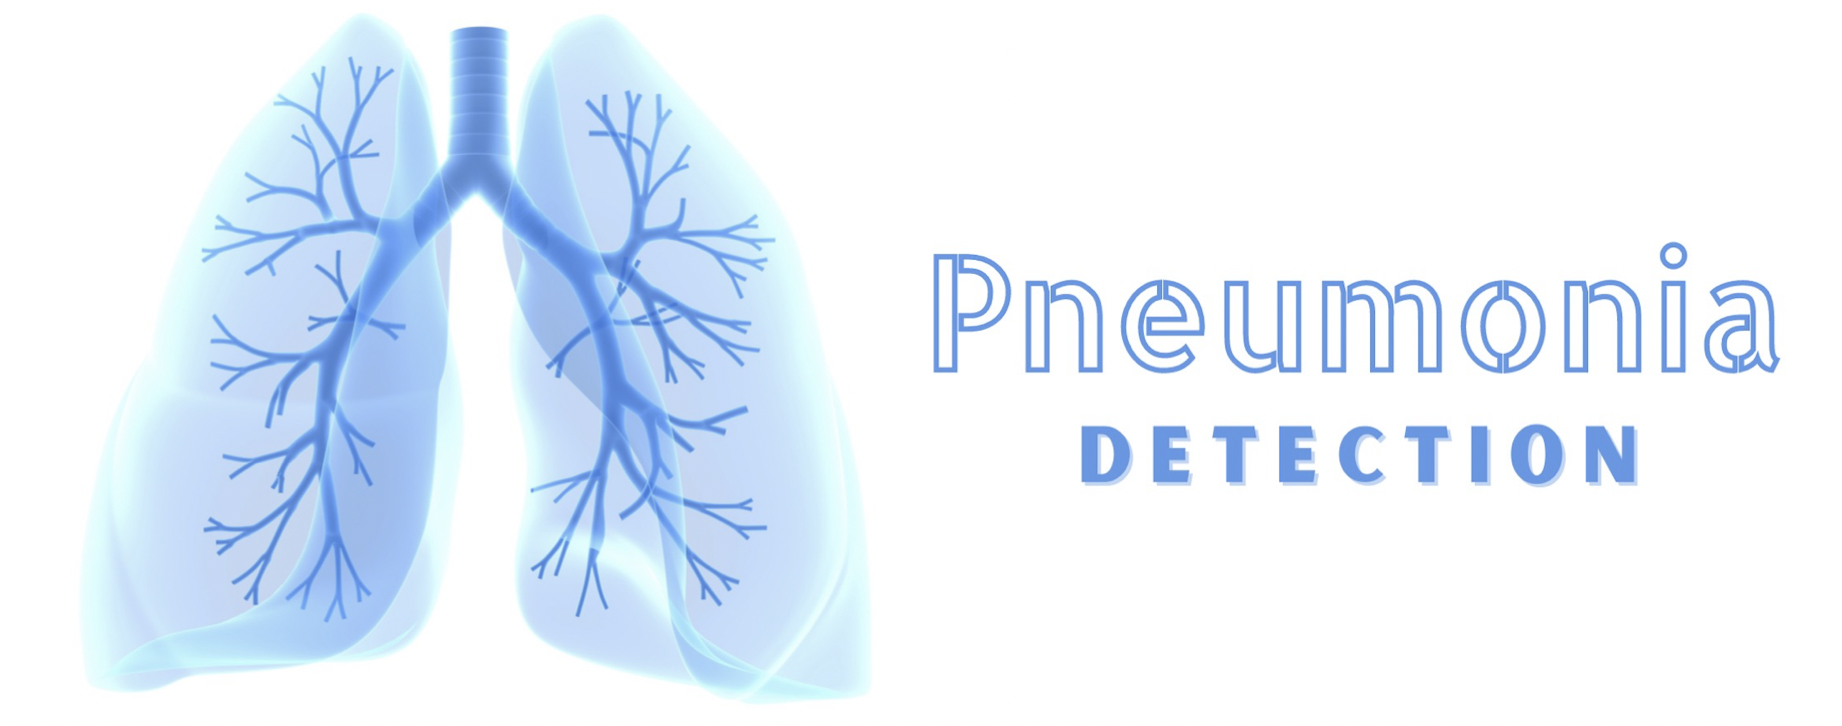
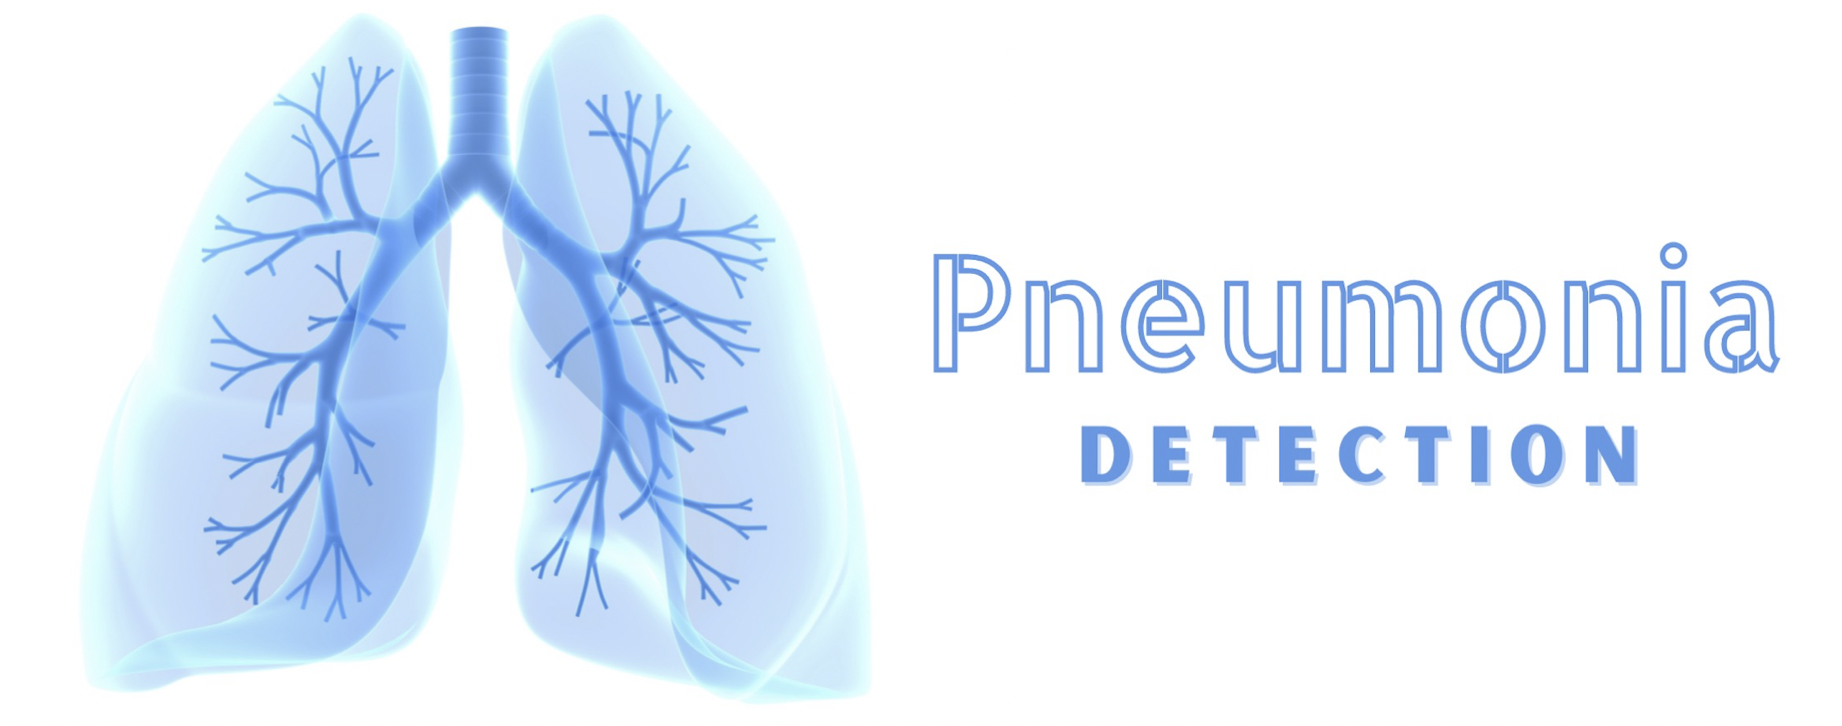
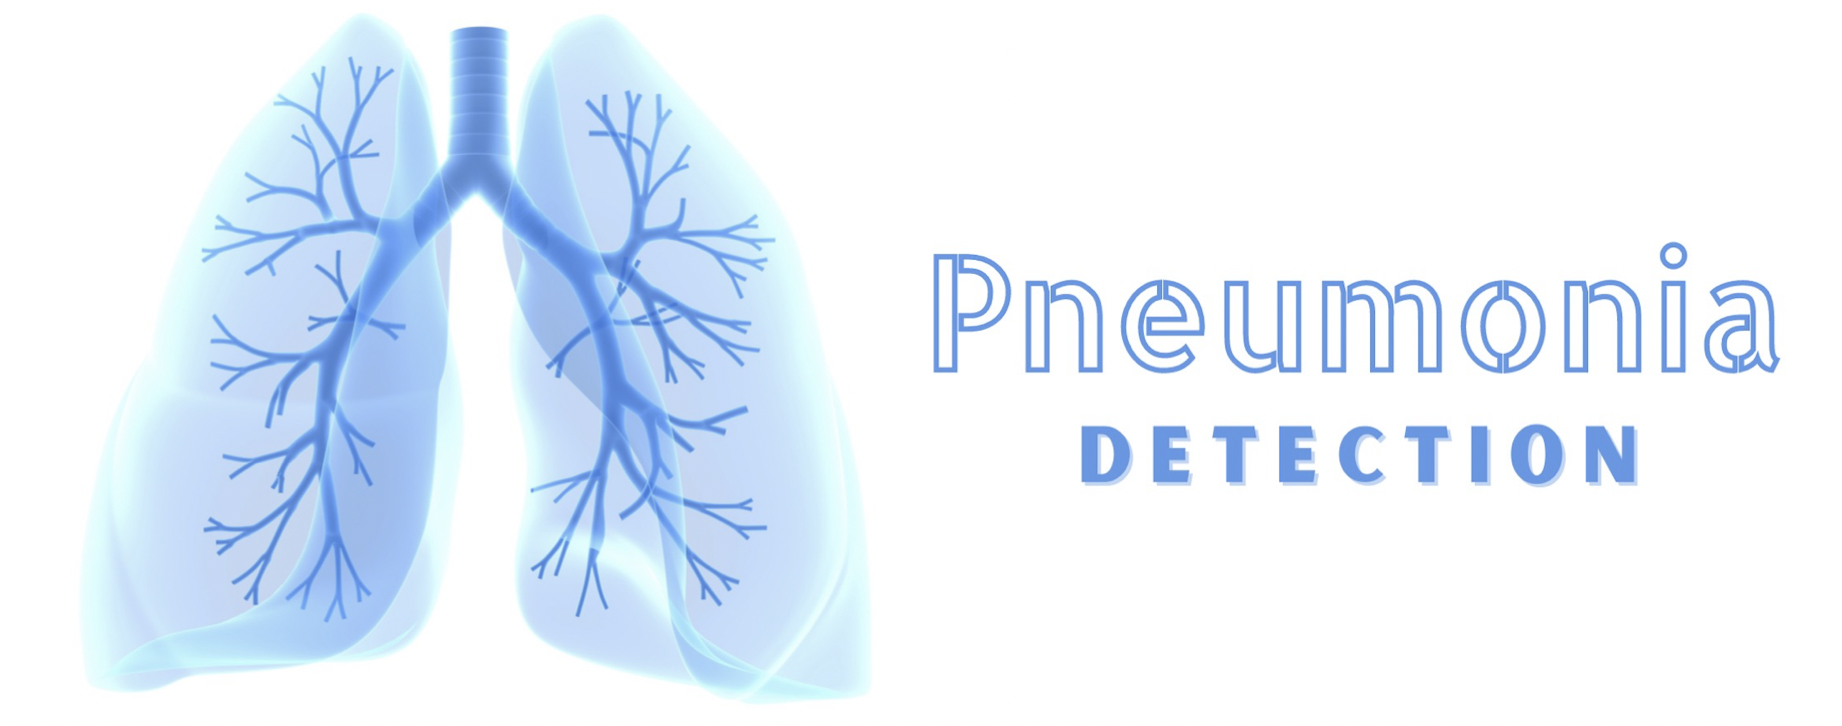

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import os
import matplotlib.image as mpimg

# Loading Data

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def loading_training_data(data_dir):
    data = []
    labels_list = []
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(resized_arr)
            labels_list.append(class_num)
            
    return np.array(data), np.array(labels_list)

# Load data for training, testing, and validation
train_data, train_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test_data, test_labels = loading_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')

# Data Visualization

In [ ]:
random_indices = np.random.choice(len(train_data), 8, replace=False)
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(train_data[idx], cmap='binary')  
    plt.title('Pneumonia' if train_labels[idx] == 0 else 'Normal')
    plt.axis('off') 

plt.suptitle("Pneumonia Sample Images", size=18)
plt.tight_layout()
plt.show()

In [ ]:
# Training Data Distribution
labels_df = pd.DataFrame({"Labels":train_labels})

plt.figure(figsize=(6,3))
sns.countplot(data = labels_df, x='Labels')
plt.xticks(ticks=[0, 1], labels=['Pneumonia', 'Normal'])
plt.show()

In [ ]:
# Testing Data Distribution
labels_df = pd.DataFrame({"Labels":test_labels})

plt.figure(figsize=(6,3))
sns.countplot(data = labels_df, x='Labels')
plt.xticks(ticks=[0, 1], labels=['Pneumonia', 'Normal'])
plt.show()

# Data Preprocessing

In [ ]:
# Normalize the data
X_train = np.array(train_data) / 255
X_test = np.array(test_data) / 255

In [ ]:
# resize data images
img_size= 128

X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(train_labels)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_labels)

# Data Augmentation

In [ ]:
# Performing Data Augmentation
data_generator = ImageDataGenerator(  
                    rotation_range = 30,
                    zoom_range = 0.2, 
                    width_shift_range=0.1,  
                    height_shift_range=0.1,  
                    horizontal_flip = True,  
                    shear_range=0.2,
                    fill_mode='nearest',
                 )


data_generator.fit(X_train)

# CNN Model

In [ ]:
model = Sequential([
    # Convolutional Layers
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)),
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(64, activation='relu'), 

    # Output Layer
    Dense(1, activation='sigmoid')
])

In [ ]:
optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(data_generator.flow(X_train,y_train, batch_size = 16),
                    epochs = 10 , validation_data = data_generator.flow(X_test, y_test))

# Training & Validation Metrics

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Epochs
epochs = range(1, 11)

# Create a figure and axes for the plots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and validation accuracy
ax[0].plot(epochs, train_acc, 'o-', color='darkgreen', label='Training Accuracy', markersize=8)
ax[0].plot(epochs, val_acc, 's--', color='darkred', label='Validation Accuracy', markersize=8)
ax[0].set_title('Training vs. Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)
ax[0].legend()
ax[0].grid(True)

# Plot training and validation loss
ax[1].plot(epochs, train_loss, 'o-', color='darkblue', label='Training Loss', markersize=8)
ax[1].plot(epochs, val_loss, 's--', color='orange', label='Validation Loss', markersize=8)
ax[1].set_title('Training vs. Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Model Performance

In [ ]:
evaluation = model.evaluate(X_test,y_test)
print("=="*20)
print(f"Accuracy - {evaluation[1]*100}%")
print(f"Loss - {evaluation[0]}")
print("=="*20)


In [ ]:
# Predicting on Test data
predictions = model.predict(X_test)
predictions = predictions.reshape(1,-1)[0]

In [ ]:
random_indices = np.random.choice(len(X_test), 10, replace=False)

# Define the figure size
plt.figure(figsize=(15, 5))

# Iterate through the selected indices
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    
    # Display the image
    plt.imshow(X_test[idx].reshape(128, 128), cmap='magma', interpolation='none')
    
    # Set the title with predicted and actual classes
    plt.title(f"Predicted: {round(predictions[idx])}   Actual: {y_test[idx]}", fontsize=10)
    
    # Remove x and y ticks
    plt.axis('off')

# Set the main title for the figure
plt.suptitle("Sample Test Images with Predictions", size=18)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()